# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/jinto/code/machlearn/udacity/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import datetime
import math
import random
from collections import namedtuple
from itertools import count

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytictoc import TicToc

%matplotlib inline

Based on DQN example available at
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
    def __init__(self, states_len, actions_len):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(states_len, states_len//2)
        self.fc2 = nn.Linear(states_len//2, states_len//4)
        self.fc3 = nn.Linear(states_len//4, actions_len)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [10]:
class DQNAgent(object):
    def __init__(self, states_len, actions_len, replay_buffer_size=50000,
                 batch_size=32, hidden_size=12, gamma=0.98):
        self.actions_len = actions_len
        self.states_len = states_len
        self.batch_size = batch_size
        self.gamma  = gamma
        self.memory = ReplayMemory(replay_buffer_size)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('Device is ', self.device)
        
        self.policy_net = DQN(self.states_len, self.actions_len).to(self.device)
        self.target_net = DQN(self.states_len, self.actions_len).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=1e-3)
#         self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        

    def update_network(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal,s in zip(non_final_mask,
                                     batch.next_state) if nonfinal > 0]
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        # about detach(): https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/7
        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon=0.05):
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
            return random.randrange(self.actions_len)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        next_state = torch.from_numpy(np.array(next_state, dtype='float32'))
        state = torch.from_numpy(np.array(state, dtype='float32'))
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        self.memory.push(state, action, next_state, reward, done)
        
    def save_model(self, filename):
        torch.save(self.policy_net.state_dict(), filename)
        
    def load_model(self, filename):
        self.policy_net.load_state_dict(torch.load(filename))

In [11]:
EPS_START = 1
EPS_END   = 0.001
EPS_DECAY = 200
TARGET_UPDATE = 10

episodes  = 1000
gamma     = 0.999
replay_buffer_size = 10000
batch_size = 64

health_print_every = 100
checkpointfile = 'banana.ckpt'
torch.manual_seed(2019)

In [12]:
actions_len = action_size
state_space_dim = state_size
hidden_layer = state_size // 2

agent = DQNAgent(state_space_dim, actions_len, replay_buffer_size, batch_size,
                  hidden_layer, gamma)

print('Policy Network is ', agent.policy_net)

Device is  cuda
Policy Network is  DQN(
  (fc1): Linear(in_features=37, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=4, bias=True)
)


In [13]:
# From https://stackoverflow.com/questions/22373927/get-traceback-of-warnings 
# in order to ignore PyTorch complaining about unit8/bool warnings
import warnings
warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

In [14]:
scores     = []
avg_score, max_avg_score = None, None
steps_done = 1

t = TicToc()
t.tic()
for ep in range(1, episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    done  = False
    eps   = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    rewards = 0
    while not done:
        action   = agent.get_action(state, eps)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward   = env_info.rewards[0]                 # get the reward
        done     = env_info.local_done[0]              # see if episode has finished
        rewards += reward

        agent.store_transition(state, action, next_state, reward, done)
        agent.update_network()

        state = next_state
        steps_done += 1

    scores.append(rewards)
    avg_score = np.mean(scores[-100:])
    elapsed   = str(datetime.timedelta(seconds = t.tocvalue())) 
    
    if max_avg_score is None or max_avg_score < avg_score:
        max_avg_score = avg_score
        
    print(f'\r{ep:5d}/{episodes}: Score = {rewards:3.2f} << Last 100 Avg = {avg_score:3.2f}, Max Avg = {max_avg_score:3.2f} >> Time Elapsed = {elapsed}    ', end='')
    
    if avg_score > 13.0:
        print(f'\n\nSolved in {ep} episodes - Received an average score of {avg_score:4.2f} in last 100')
        agent.save_model(checkpointfile)
        break

    if ep % TARGET_UPDATE == 0:
        if ep % health_print_every == 0:
            print('')
        agent.update_target_network()

print(f'Training completed. Model saved to {checkpointfile}')

  100/1000: Score = 0.00 << Last 100 Avg = 3.78, Max Avg = 3.88 >> Time Elapsed = 0:02:00.557771      
  200/1000: Score = 11.00 << Last 100 Avg = 8.83, Max Avg = 8.83 >> Time Elapsed = 0:04:02.037656    
  300/1000: Score = 10.00 << Last 100 Avg = 11.31, Max Avg = 11.36 >> Time Elapsed = 0:06:02.983556    
  384/1000: Score = 12.00 << Last 100 Avg = 13.03, Max Avg = 13.03 >> Time Elapsed = 0:07:44.522643    

Solved in 384 episodes - Received an average score of 13.03 in last 100
Training completed. Model saved to banana.ckpt


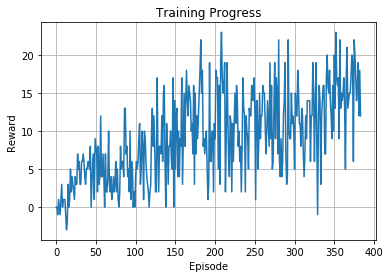

In [15]:
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.plot(scores)

In [16]:
# Play the game with learned model
games = 5

agent = DQNAgent(state_space_dim, actions_len, replay_buffer_size, batch_size, hidden_layer, gamma)
agent.load_model(checkpointfile)
t = TicToc()
t.tic()
for game in range(1, games + 1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.get_action(state)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        print(f'\rGame {game:2d}: Total Score = {score:4.2f}', end='')
        if done:                                       # exit loop if episode finished
            print(f' Done after {t.tocvalue():5.2f} seconds')
            break
print(f'All {games} games played')

Device is  cuda
Game  1: Total Score = 16.00 Done after 29.93 seconds
Game  2: Total Score = 13.00 Done after 59.97 seconds
Game  3: Total Score = 14.00 Done after 90.00 seconds
Game  4: Total Score = 18.00 Done after 120.02 seconds
Game  5: Total Score = 13.00 Done after 150.03 seconds
All 5 games played


In [17]:
env.close()